### Рекомендательные системы
Небольшой интернет-магазин попросил вас добавить ранжирование товаров в блок "Смотрели ранее" - в нем теперь надо показывать не последние просмотренные пользователем товары, а те товары из просмотренных, которые он наиболее вероятно купит. Качество вашего решения будет оцениваться по количеству покупок в сравнении с прошлым решением в ходе А/В теста, т.к. по доходу от продаж статзначимость будет достигаться дольше из-за разброса цен. Таким образом, ничего заранее не зная про корреляцию оффлайновых и онлайновых метрик качества, в начале проекта вы можете лишь постараться оптимизировать ```recall@k``` и ```precision@k```.  

Это задание посвящено построению простых бейзлайнов для этой задачи: ранжирование просмотренных товаров по частоте просмотров и по частоте покупок. Эти бейзлайны, с одной стороны, могут помочь вам грубо оценить возможный эффект от ранжирования товаров в блоке - например, чтобы вписать какие-то числа в коммерческое предложение заказчику, а с другой стороны, могут оказаться самым хорошим вариантом, если данных очень мало (недостаточно для обучения даже простых моделей).

### Входные данные
Вам дается две выборки с пользовательскими сессиями:
- id просмотренных товаров
- id купленных товаров

Одна выборка будет использоваться для обучения (оценки популярностей товаров), а другая - для теста.

В файлах записаны сессии по одной в каждой строке. Формат сессии: id просмотренных товаров через ```,``` затем после ```;``` следуют id купленных товаров (если такие имеются, например: ```1,2,3,4;5,6```)

Гарантируется, что среди id купленных товаров все различные.

**Важно**
- Сессии, в которых пользователь ничего не купил, исключаем из оценки качества
- Если товар не встречался в обучающей выборке, его популярность равна 0
- Рекомендуем разные товары. И их число должно быть не больше, чем количество различных просмотренных пользователем товаров
- Рекомендаций всегда не больше, чем минимум из двух чисел: количество просмотренных пользователем товаров и k в ```recall@k``` / ```precision@k```.

In [224]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

### Загрузка данных
Так как необходимо будет обработать 2 выборки: train и test, то загрузим выборки сразу. Генерацию всех признаков и вычислений будем оформлять в виде функцию, для удобного применения к train и test.

In [225]:
cd C:\Users\vlad\Machine_Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\data

C:\Users\vlad\Machine_Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\data


In [240]:
data_train = pd.read_csv('sessions_train.txt', sep=';', header=None, names=['viewed_goods', 'bought_goods'])
data_test = pd.read_csv('sessions_test.txt', sep=';', header=None, names=['viewed_goods', 'bought_goods'])

initial_train_size = data_train.shape[0]
initial_test_size = data_test.shape[0]

print('Train Size: ', initial_train_size)
print('Test Size: ', initial_test_size)

Train Size:  50000
Test Size:  50000


Преобразуем train и test к необходимому формату

In [241]:
# Преобразуем все значение просмотренных товаров как массивы numpy
data_train['viewed_goods'] = data_train['viewed_goods'].apply(lambda x: np.array(x.split(','), dtype='int') if type(x)== str else x)
data_train['bought_goods'] = data_train['bought_goods'].apply(lambda x: np.array(x.split(','), dtype='int') if type(x)== str else x)

data_test['viewed_goods'] = data_test['viewed_goods'].apply(lambda x: np.array(x.split(','), dtype='int') if type(x)== str else x)
data_test['bought_goods'] = data_test['bought_goods'].apply(lambda x: np.array(x.split(','), dtype='int') if type(x)== str else x)

**1)** На обучении постройте частоты появления id в просмотренных и в купленных (id может несколько раз появляться в просмотренных, все появления надо учитывать)

In [242]:
# Создадим столбец частоты просмотренных товаров (группы - частоты (популярность просмотров))

def create_goods_views_groups(df):
    # Пробегаемся по всем сессиям
    product_groups = []
    for indx in range(df.shape[0]):

        # 1. Определяем уникальные ids товаров и их частоты 
        unique_ids_and_counts = np.unique(df['viewed_goods'].iloc[indx], return_counts=True)

        # 2. Определяем уникальные группы по просмотрам 
        unique_ids_count_groups = np.unique(unique_ids_and_counts[1])

        # 3. Пробегаемся по всем уникальным группам по просмотрам
        id_groups = {}
        for group_value in unique_ids_count_groups:
            # Создаем соответствующую группу просмотров товаров путем сопоставления частот товаров их изначальной последоательности
            id_groups[group_value] = unique_ids_and_counts[0][np.where(unique_ids_and_counts[1] == group_value)]

        product_groups.append(id_groups)
        
    return product_groups

# Создаем столбец с соответствующими группами по частотам 
data_train['viewed_goods_groups'] = create_goods_views_groups(data_train)

In [243]:
# Теперь определим частоты по покупкам (число покупок - группа для товаров)

def create_purchase_groups(df):
    purchase_groups = []
    for indx in range(df.shape[0]):

        # 1. Определяем список уникальных товаров
        unique_prod = np.unique(df['viewed_goods'].iloc[indx])

        # 2. Определяем списокб, соответствующие покупался ли товар или нет (индекс списка == индексу товара в списке товаров)
        is_prod_bought = np.isin(np.unique(df['viewed_goods'].iloc[indx]), df['bought_goods'].iloc[indx]).astype('int')

        # 3. Определяем какие группы по покупкам есть (0: товары не покупались, 1: товары покупались 1 раз и.т.д.)
        bought_prod_groups = np.unique(is_prod_bought)

        # 4. Для каждой группы покупок определяем ее товары
        bought_groups = {}
        for group in bought_prod_groups:
            bought_groups[group] = unique_prod[np.where(is_prod_bought == group)]

        purchase_groups.append(bought_groups)
    
    return purchase_groups
    
# Создаем соответствующие столбцы
data_train['bought_goods_groups'] = create_purchase_groups(data_train)

Так как частоты по просмотрам и покупкам должны быть отобраны только для train, то отберем их

In [244]:
freqs = data_train[['viewed_goods_groups', 'bought_goods_groups']]
freqs

,viewed_goods_groups,bought_goods_groups
0,"{1: [0, 1, 2, 3, 4, 5]}","{0: [0, 1, 2, 3, 4, 5]}"
1,"{1: [10, 12], 3: [9, 11]}","{0: [9, 10, 11, 12]}"
2,"{1: [16, 17, 18, 19, 20, 21]}","{0: [16, 17, 18, 19, 20, 21]}"
3,"{1: [25, 26, 27], 2: [24]}","{0: [24, 25, 26, 27]}"
4,"{2: [34, 35, 36, 37, 38, 39]}","{0: [34, 35, 36, 37, 38, 39]}"
...,...,...
49995,"{1: [38220, 60520], 2: [32291]}","{0: [38220, 60520], 1: [32291]}"
49996,"{1: [28288, 60479, 102804, 102805]}","{0: [28288, 60479, 102804, 102805]}"
49997,"{4: [980, 20025]}","{0: [980, 20025]}"
49998,"{1: [352, 6681, 8172, 8827, 8838, 8847, 29237,...","{0: [352, 6681, 8172, 8827, 8838, 8844, 8847, ..."


Объединим тестовую выборку со значениями частот посчитанных на train

In [245]:
data_test[['viewed_goods_groups', 'bought_goods_groups']] = freqs

Теперь избавимся от пропущенных значений в покупках для train и test

In [246]:
data_train.dropna(inplace = True)
data_test.dropna(inplace = True)

In [247]:
data_train

,viewed_goods,bought_goods,viewed_goods_groups,bought_goods_groups
7,"[59, 60, 61, 62, 60, 63, 64, 65, 66, 61, 67, 6...","[67, 60, 63]","{1: [59, 62, 63, 64, 65, 66, 68], 2: [60, 61, ...","{0: [59, 61, 62, 64, 65, 66, 68], 1: [60, 63, ..."
10,"[84, 85, 86, 87, 88, 89, 84, 90, 91, 92, 93, 86]",[86],"{1: [85, 87, 88, 89, 90, 91, 92, 93], 2: [84, ...","{0: [84, 85, 87, 88, 89, 90, 91, 92, 93], 1: [..."
19,"[138, 198, 199, 127]",[199],"{1: [127, 138, 198, 199]}","{0: [127, 138, 198], 1: [199]}"
30,"[303, 304, 305, 306, 307, 308, 309, 310, 311, ...",[303],"{1: [303, 304, 305, 306, 307, 308, 309, 310, 3...","{0: [304, 305, 306, 307, 308, 309, 310, 311, 3..."
33,"[352, 353, 352]",[352],"{1: [353], 2: [352]}","{0: [353], 1: [352]}"
...,...,...,...,...
49943,"[41795, 4337, 4335, 4337, 4335, 24087, 4335, 4...",[4335],"{1: [4344, 24087, 57885, 97147], 2: [4337, 240...","{0: [4337, 4344, 24073, 24087, 41795, 44763, 5..."
49964,"[6366, 15269, 6366, 5895, 6366, 5895]",[5895],"{1: [15269], 2: [5895], 3: [6366]}","{0: [6366, 15269], 1: [5895]}"
49981,"[64552, 25931, 2807]","[25935, 2807]","{1: [2807, 25931, 64552]}","{0: [25931, 64552], 1: [2807]}"
49991,"[91921, 20251, 5063, 21742, 5063, 20251, 34927]",[91921],"{1: [21742, 34927, 91921], 2: [5063, 20251]}","{0: [5063, 20251, 21742, 34927], 1: [91921]}"


In [248]:
data_test

,viewed_goods,bought_goods,viewed_goods_groups,bought_goods_groups
7,"[63, 68, 69, 70, 66, 61, 59, 61, 66, 68]","[66, 63]","{1: [59, 62, 63, 64, 65, 66, 68], 2: [60, 61, ...","{0: [59, 61, 62, 64, 65, 66, 68], 1: [60, 63, ..."
14,"[158, 159, 160, 159, 161, 162]",[162],"{1: [93, 97, 156, 157], 2: [155]}","{0: [93, 97, 155, 156, 157]}"
19,"[200, 201, 202, 203, 204]","[201, 205]","{1: [127, 138, 198, 199]}","{0: [127, 138, 198], 1: [199]}"
34,"[371, 372, 371]","[371, 373]","{1: [178, 179, 361, 362, 363, 364, 365, 366, 3...","{0: [178, 179, 361, 362, 363, 364, 365, 366, 3..."
40,[422],[422],"{1: [413, 414, 415, 416, 417, 418, 419, 420, 4...","{0: [413, 414, 415, 416, 417, 418, 419, 420, 4..."
...,...,...,...,...
49943,"[2859, 2854, 88887, 96997, 4439, 28645, 99975,...","[24907, 102691, 18496, 4333]","{1: [4344, 24087, 57885, 97147], 2: [4337, 240...","{0: [4337, 4344, 24073, 24087, 41795, 44763, 5..."
49944,"[77655, 23249, 1306, 47450, 26157, 58205, 4745...","[58205, 3111, 69482]","{1: [2964, 69417]}","{0: [2964, 69417]}"
49945,"[60538, 44430, 66252, 44430, 60538, 66251]","[66252, 44430]","{1: [7324, 7330, 15530, 18736, 18953, 24122, 2...","{0: [7324, 7330, 15530, 18736, 18953, 24122, 2..."
49946,"[49815, 76363]",[49815],"{1: [9272, 11990, 26305, 30591, 33525, 33558, ...","{0: [9272, 11990, 26305, 30591, 33525, 33558, ..."


По условию мы должны создать 2 рекомендательные системы:
- По популярности 
- По покупкам

Т.к. в сессиях есть поля где пользователь ничего не купил, то для оценки качества алгоритма рекомендация по покупкам мы и такие записи исключим, а по популярности оставим (т.к. это необходимые данные для оценки качества)

Основной сложностью является то, что товары должны быть отсортированы не только по популярности/покупаемости, но и учитывая как их просматривал пользователь, у товаров с одинаковым числом просмотров, наиболее актуальным будет тот, который пользователь посмотрел первым. 

Именно поэтому я разделил товары на группы по популярности и продаваемости


**2)** Реализуйте два алгоритма рекомендаций:
- Cортировка просмотренных id по популярности (частота появления в просмотренных),
- Cортировка просмотренных id по покупаемости (частота появления в покупках)

Важным моментом является то, что **если частота одинаковая, то сортировать нужно по возрастанию момента просмотра (чем раньше появился в просмотренных, тем больше приоритет)**

In [249]:
def sort_goods(df, column='viewed_goods_groups'):
    sorted_ids = []
    # 1. Сопоставим товарам в каждой группе индекс их первого появления в сессии пользователя
    
    for indx in range(df.shape[0]):
        # 1. Здесь храним группы с товарами и индексами их появления в сессии пользователя
        groups_with_goods_ids = {}
        
        # 2. Получаем доступ к группам и товарам в группе
        for group in df[column].iloc[indx].items():
            # 3. 3десь храним товары и их индексы появления в сессии пользователя
            goods_ids = {}
            # 4. Пробегаемся по всем товарам
            for value in group[1]:
                # В сесии возможны новые товары, которые мы не видели в обучении, по условию,
                # популярность такого товара должна быть 0, сделаем данную проверку
                if np.isin(value, df['viewed_goods'].iloc[indx]):
                    # 5. Для каждого товара определяем его индекс в сесии пользователя
                    goods_ids[value] = np.where(df['viewed_goods'].iloc[indx] == value)[0][0]
                else:
                    goods_ids[value] = 1000
            # 6. Сохраняем группу с товарами и их порядком в сессии (индексы)
            groups_with_goods_ids[group[0]] = goods_ids
        
        sorted_goods_ids = []
        # 7. Пробегаемся по группам с товарами и их порядком начиная с самой большой группы, т.к. учитываем популярность  
        for group in list(groups_with_goods_ids.keys())[::-1]:
            # 8. Каждая группа товаров сортируется независимо, учитывая порядок в сессии
            sorted_goods_ids += list(dict(sorted(groups_with_goods_ids[group].items(), key=lambda x: x[1])).keys())
        sorted_ids.append(sorted_goods_ids)
        
    return sorted_ids  

In [250]:
data_train['sorted_by_popylarity'] = sort_goods(df=data_train, column='viewed_goods_groups')
data_train['sorted_by_purchase'] = sort_goods(df=data_train, column='bought_goods_groups')

data_test['sorted_by_popylarity'] = sort_goods(df=data_test, column='viewed_goods_groups')
data_test['sorted_by_purchase'] = sort_goods(df=data_test, column='bought_goods_groups')

In [251]:
# Train DF
data_train

,viewed_goods,bought_goods,viewed_goods_groups,bought_goods_groups,sorted_by_popylarity,sorted_by_purchase
7,"[59, 60, 61, 62, 60, 63, 64, 65, 66, 61, 67, 6...","[67, 60, 63]","{1: [59, 62, 63, 64, 65, 66, 68], 2: [60, 61, ...","{0: [59, 61, 62, 64, 65, 66, 68], 1: [60, 63, ...","[60, 61, 67, 59, 62, 63, 64, 65, 66, 68]","[60, 63, 67, 59, 61, 62, 64, 65, 66, 68]"
10,"[84, 85, 86, 87, 88, 89, 84, 90, 91, 92, 93, 86]",[86],"{1: [85, 87, 88, 89, 90, 91, 92, 93], 2: [84, ...","{0: [84, 85, 87, 88, 89, 90, 91, 92, 93], 1: [...","[84, 86, 85, 87, 88, 89, 90, 91, 92, 93]","[86, 84, 85, 87, 88, 89, 90, 91, 92, 93]"
19,"[138, 198, 199, 127]",[199],"{1: [127, 138, 198, 199]}","{0: [127, 138, 198], 1: [199]}","[138, 198, 199, 127]","[199, 138, 198, 127]"
30,"[303, 304, 305, 306, 307, 308, 309, 310, 311, ...",[303],"{1: [303, 304, 305, 306, 307, 308, 309, 310, 3...","{0: [304, 305, 306, 307, 308, 309, 310, 311, 3...","[303, 304, 305, 306, 307, 308, 309, 310, 311, ...","[303, 304, 305, 306, 307, 308, 309, 310, 311, ..."
33,"[352, 353, 352]",[352],"{1: [353], 2: [352]}","{0: [353], 1: [352]}","[352, 353]","[352, 353]"
...,...,...,...,...,...,...
49943,"[41795, 4337, 4335, 4337, 4335, 24087, 4335, 4...",[4335],"{1: [4344, 24087, 57885, 97147], 2: [4337, 240...","{0: [4337, 4344, 24073, 24087, 41795, 44763, 5...","[4335, 41795, 4337, 24073, 44763, 24087, 4344,...","[4335, 41795, 4337, 24087, 24073, 4344, 57885,..."
49964,"[6366, 15269, 6366, 5895, 6366, 5895]",[5895],"{1: [15269], 2: [5895], 3: [6366]}","{0: [6366, 15269], 1: [5895]}","[6366, 5895, 15269]","[5895, 6366, 15269]"
49981,"[64552, 25931, 2807]","[25935, 2807]","{1: [2807, 25931, 64552]}","{0: [25931, 64552], 1: [2807]}","[64552, 25931, 2807]","[2807, 64552, 25931]"
49991,"[91921, 20251, 5063, 21742, 5063, 20251, 34927]",[91921],"{1: [21742, 34927, 91921], 2: [5063, 20251]}","{0: [5063, 20251, 21742, 34927], 1: [91921]}","[20251, 5063, 91921, 21742, 34927]","[91921, 20251, 5063, 21742, 34927]"


In [252]:
data_test

,viewed_goods,bought_goods,viewed_goods_groups,bought_goods_groups,sorted_by_popylarity,sorted_by_purchase
7,"[63, 68, 69, 70, 66, 61, 59, 61, 66, 68]","[66, 63]","{1: [59, 62, 63, 64, 65, 66, 68], 2: [60, 61, ...","{0: [59, 61, 62, 64, 65, 66, 68], 1: [60, 63, ...","[61, 60, 67, 63, 68, 66, 59, 62, 64, 65]","[63, 60, 67, 68, 66, 61, 59, 62, 64, 65]"
14,"[158, 159, 160, 159, 161, 162]",[162],"{1: [93, 97, 156, 157], 2: [155]}","{0: [93, 97, 155, 156, 157]}","[155, 93, 97, 156, 157]","[93, 97, 155, 156, 157]"
19,"[200, 201, 202, 203, 204]","[201, 205]","{1: [127, 138, 198, 199]}","{0: [127, 138, 198], 1: [199]}","[127, 138, 198, 199]","[199, 127, 138, 198]"
34,"[371, 372, 371]","[371, 373]","{1: [178, 179, 361, 362, 363, 364, 365, 366, 3...","{0: [178, 179, 361, 362, 363, 364, 365, 366, 3...","[178, 179, 361, 362, 363, 364, 365, 366, 367, ...","[178, 179, 361, 362, 363, 364, 365, 366, 367, ..."
40,[422],[422],"{1: [413, 414, 415, 416, 417, 418, 419, 420, 4...","{0: [413, 414, 415, 416, 417, 418, 419, 420, 4...","[413, 414, 415, 416, 417, 418, 419, 420, 421]","[413, 414, 415, 416, 417, 418, 419, 420, 421]"
...,...,...,...,...,...,...
49943,"[2859, 2854, 88887, 96997, 4439, 28645, 99975,...","[24907, 102691, 18496, 4333]","{1: [4344, 24087, 57885, 97147], 2: [4337, 240...","{0: [4337, 4344, 24073, 24087, 41795, 44763, 5...","[4335, 4337, 24073, 41795, 44763, 4344, 24087,...","[4335, 4337, 4344, 24073, 24087, 41795, 44763,..."
49944,"[77655, 23249, 1306, 47450, 26157, 58205, 4745...","[58205, 3111, 69482]","{1: [2964, 69417]}","{0: [2964, 69417]}","[2964, 69417]","[2964, 69417]"
49945,"[60538, 44430, 66252, 44430, 60538, 66251]","[66252, 44430]","{1: [7324, 7330, 15530, 18736, 18953, 24122, 2...","{0: [7324, 7330, 15530, 18736, 18953, 24122, 2...","[7324, 7330, 15530, 18736, 18953, 24122, 24125...","[7324, 7330, 15530, 18736, 18953, 24122, 24125..."
49946,"[49815, 76363]",[49815],"{1: [9272, 11990, 26305, 30591, 33525, 33558, ...","{0: [9272, 11990, 26305, 30591, 33525, 33558, ...","[9272, 11990, 26305, 30591, 33525, 33558, 6886...","[9272, 11990, 26305, 30591, 33525, 33558, 6886..."


**3)** Для данных алгоритмов выпишите через пробел:
- AverageRecall@1
- AveragePrecision@1
- AverageRecall@5
- AveragePrecision@5

на обучающей и тестовых выборках, округляя до 2 знака после запятой. Это будут ваши ответы в этом задании. Посмотрите, как они соотносятся друг с другом. Где качество получилось выше? Значимо ли это различие? Обратите внимание на различие качества на обучающей и тестовой выборке в случае рекомендаций по частотам покупки.

При этом нужно учесть следующее: если алгоритм рекомендовал скажем 2, а мы хотим вычислить precision@5 (зная истинный ответ)то по смыслу этой метрики мы хотим измерить точность на глубине рекомендаций все таки именно 5, поэтому считаем что рекомендовавший алгоритм остальные 3 точно не угадал, поэтому нужно делить на 5, а не на 2.

In [262]:
# Метрика для расчета Полноты, усредненной по всем сессиям
def avg_recall_k(df, k=1, col_1='bought_goods', col_2='sorted_by_popylarity'):
    recalls_k = []
        
    for indx in range(df.shape[0]):
        bough_k = np.isin(df[col_2].iloc[indx][:k], df[col_1].iloc[indx]).sum()
        n_purchase = df[col_1].iloc[indx].shape[0]

        recalls_k.append(bough_k/n_purchase)
        
    return sum(recalls_k)/df.shape[0]

# Метрика для расчета Точности, усредненной по всем сессиям
def avg_precision_k(df, k=1, col_1='bought_goods', col_2='sorted_by_popylarity'):
    precisions_k = []
    for indx in range(df.shape[0]):
        bough_k = np.isin(df[col_2].iloc[indx][:k], df[col_1].iloc[indx]).sum()
        precisions_k.append(bough_k/k)
        
    return sum(precisions_k)/df.shape[0]

Оцениваем метрики на **train**

In [263]:
# Расчитываем основные метрики для первого алгоритма (Сортировка по популярности просматриваемых товаров)
avg_recall_1k_pop_train = avg_recall_k(df=data_train, k=1)
avg_prec_1k_pop_train = avg_precision_k(df=data_train, k=1)
avg_recall_5k_pop_train = avg_recall_k(df=data_train, k=5)
avg_prec_5k_pop_train = avg_precision_k(df=data_train, k=5)

# Расчитываем основные метрики для второго алгоритма (Сортировка по покупаемсоти просматриваемых товаров)
avg_recall_1k_purch_train = avg_recall_k(df=data_train, k=1, col_2='sorted_by_purchase')
avg_prec_1k_purch_train = avg_precision_k(df=data_train, k=1, col_2='sorted_by_purchase')
avg_recall_5k_purch_train = avg_recall_k(df=data_train, k=5, col_2='sorted_by_purchase')
avg_prec_5k_purch_train = avg_precision_k(df=data_train, k=5, col_2='sorted_by_purchase')

Оцениваем метрики на **test**

In [264]:
# Расчитываем основные метрики для первого алгоритма (Сортировка по популярности просматриваемых товаров)
avg_recall_1k_pop_test = avg_recall_k(df=data_test, k=1)
avg_prec_1k_pop_test = avg_precision_k(df=data_test, k=1)
avg_recall_5k_pop_test = avg_recall_k(df=data_test, k=5)
avg_prec_5k_pop_test = avg_precision_k(df=data_test, k=5)

# Расчитываем основные метрики для второго алгоритма (Сортировка по покупаемсоти просматриваемых товаров)
avg_recall_1k_purch_test = avg_recall_k(df=data_test, k=1, col_2='sorted_by_purchase')
avg_prec_1k_purch_test = avg_precision_k(df=data_test, k=1, col_2='sorted_by_purchase')
avg_recall_5k_purch_test = avg_recall_k(df=data_test, k=5, col_2='sorted_by_purchase')
avg_prec_5k_purch_test = avg_precision_k(df=data_test, k=5, col_2='sorted_by_purchase')

### Сохраняем результаты

In [265]:
cd C:\Users\vlad\Machine_Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\submissions

C:\Users\vlad\Machine_Learning\Yandex Specialization\5.Applied Tasks Of Data Analysis\submissions


In [266]:
def save_results(f_name, array):
    with open(f_name, 'w') as f:
        f.write(' '.join([str(round(value, 2)) for value in array]))
    
save_results('rec_sys_pop_sort_train.txt',
             [avg_recall_1k_pop_train,
              avg_prec_1k_pop_train,
              avg_recall_5k_pop_train,
              avg_prec_5k_pop_train
             ])

save_results('rec_sys_pop_sort_test.txt',
             [avg_recall_1k_pop_test,
              avg_prec_1k_pop_test,
              avg_recall_5k_pop_test,
              avg_prec_5k_pop_test
             ])

save_results('rec_sys_purch_sort_train.txt',
             [avg_recall_1k_purch_train,
              avg_prec_1k_purch_train,
              avg_recall_5k_purch_train,
              avg_prec_5k_purch_train
             ])

save_results('rec_sys_purch_sort_test.txt',
             [avg_recall_1k_purch_test,
              avg_prec_1k_purch_test,
              avg_recall_5k_purch_test,
              avg_prec_5k_purch_test
             ])

### Сопоставление метрик 
Сравним качество нашего алгоритма на обучении и на тесте

In [267]:
index = [
    'AvgRecall@1Pop',
    'AvgRecall@5Pop',
    'AvgPrecision@1Pop',
    'AvgPrecision@5Pop',
    
    'AvgRecall@1Purch',
    'AvgRecall@5Purch',
    'AvgPrecision@1Purch',
    'AvgPrecision@5Purch'
]

metrics_dic = {
    
    'train': [
        avg_recall_1k_pop_train,
        avg_recall_5k_pop_train,
        avg_prec_1k_pop_train,
        avg_prec_5k_pop_train,
        
        avg_recall_1k_purch_train,
        avg_recall_5k_purch_train,
        avg_prec_1k_purch_train,
        avg_prec_5k_purch_train
    ],
    
    'test': [
        avg_recall_1k_pop_test,
        avg_recall_5k_pop_test,
        avg_prec_1k_pop_test,
        avg_prec_5k_pop_test,

        avg_recall_1k_purch_test,
        avg_recall_5k_purch_test,
        avg_prec_1k_purch_test,
        avg_prec_5k_purch_test
    ]
}

metrics_df = pd.DataFrame(metrics_dic, index=index)
metrics_df

,train,test
AvgRecall@1Pop,0.545682,0.046747
AvgRecall@5Pop,0.867684,0.076407
AvgPrecision@1Pop,0.643847,0.062756
AvgPrecision@5Pop,0.228769,0.023302
AvgRecall@1Purch,0.829458,0.050110
AvgRecall@5Purch,0.941814,0.077744
AvgPrecision@1Purch,0.979767,0.067121
AvgPrecision@5Purch,0.262472,0.023574


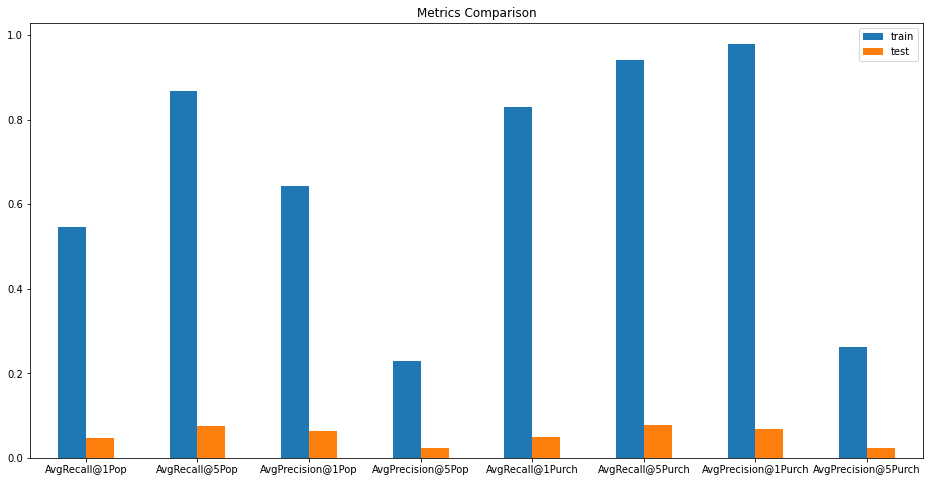

In [268]:
metrics_df.plot(kind='bar', figsize=(16,8))
plt.xticks(rotation=0)
plt.title('Metrics Comparison');